# Importing The libraries

In [1]:
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from dataclasses import dataclass
import hvplot.pandas 
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

We'll just be loading the unit 5 training and synthetic dataset

In [2]:
dataset_root = Path(r"./dataset") # Raw string works without escaping \


@dataclass
class Case():
    info: pd.DataFrame
    measurements: pd.DataFrame


class RawDataset():

    def __init__(self, root, unit = "VG4", load_training=False, load_synthetic=False) -> None:
        
        
        read_pq_file = lambda f: pq.read_table(root / f).to_pandas()
        
        
        cases = {
            "test": [f"{unit}_generator_data_testing_real_measurements.parquet", root / f"{unit}_generator_data_testing_real_info.csv" ], 
        }
        
        if load_training:
            cases = {
                **cases,
                "train": [f"{unit}_generator_data_training_measurements.parquet", root / f"{unit}_generator_data_training_info.csv" ], 
            }
        
        if load_synthetic:
            cases = {
                **cases,
                "test_s01": [f"{unit}_generator_data_testing_synthetic_01_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_01_info.csv"], 
                "test_s02": [f"{unit}_generator_data_testing_synthetic_02_measurements.parquet", root / f"{unit}_generator_data_testing_synthetic_02_info.csv"]
            }
        
        
        self.data_dict = dict()
        
        for id_c, c in cases.items():
            # if you need to verify the parquet header:
            # pq_rows = RawDataset.read_parquet_schema_df(root / c[0])
            info = pd.read_csv(c[1])
            measurements = read_pq_file(c[0])
            self.data_dict[id_c] = Case(info, measurements)
            
        
        
    @staticmethod
    def read_parquet_schema_df(uri: str) -> pd.DataFrame:
        """Return a Pandas dataframe corresponding to the schema of a local URI of a parquet file.

        The returned dataframe has the columns: column, pa_dtype
        """
        # Ref: https://stackoverflow.com/a/64288036/
        schema = pq.read_schema(uri, memory_map=True)
        schema = pd.DataFrame(({"column": name, "pa_dtype": str(pa_dtype)} for name, pa_dtype in zip(schema.names, schema.types)))
        schema = schema.reindex(columns=["column", "pa_dtype"], fill_value=pd.NA)  # Ensures columns in case the parquet file has an empty dataframe.
        return schema




rds_u5 = RawDataset(dataset_root, "VG5", load_synthetic=True, load_training=True)

# Splitting the dataframes

The dataframes are split between the time series measured by the sensors ($Y_t$), the control time series ($X_t$) and the operating modes (OP).

In [3]:
Operating_modes_name = ["turbine_mode",
                        "equilibrium_turbine_mode",
                        "pump_mode",
                        "equilibrium_pump_mode",
                        "short_circuit_mode",
                        "equilibrium_short_circuit_mode",
                        "machine_on",
                        "machine_off",
                        "dyn_only_on",
                        "all"]

def extracting_name_groups_time_series(rds, set_type="train"):
    """This function fetches the name of the control and sensors time series

    Args:
        rds (class RawDataSet): _description_
        set_type (str, optional): _description_. Defaults to "train".

    Returns:
        2 lists: they hold the names of the two groups
    """
    df_name_control_sensors = rds.data_dict[set_type].info
    
    control_time_series_name = df_name_control_sensors[(df_name_control_sensors['control_signal']==True) 
                                            & (df_name_control_sensors["signal_type"]=="Measurement")]
    
    sensors_time_series_name = df_name_control_sensors[(df_name_control_sensors['control_signal']==False) 
                                            & (df_name_control_sensors["signal_type"]=="Measurement")]
    return control_time_series_name["attribute_name"], sensors_time_series_name["attribute_name"]


def extracting_groups_time_series(rds, set_type="train"):
    """The function extracts the control, sensors and operating modes time series out of the main one.
    It can be specified on which type of dataset it is done (train, test, synthetic).

    Args:
        rds (class RawDataSet): _description_
        set_type (str, optional): Choose the type of dataset. Defaults to "train".

    Returns:
        _type_: _description_
    """
    control_time_series_name, sensors_time_series_name = extracting_name_groups_time_series(rds, set_type=set_type)
    
    control_df = rds.data_dict[set_type].measurements[control_time_series_name]
    
    sensors_df = rds.data_dict[set_type].measurements[sensors_time_series_name]
    
    operating_modes_df = rds.data_dict[set_type].measurements[Operating_modes_name]
    
    return control_df, sensors_df, operating_modes_df

def get_indexes_operating_mode(operating_modes_df, operating_conditions):
    """
    Get the indexes of the rows in the DataFrame that satisfy all the conditions in the dictionary.

    Parameters:
    operating_modes_df (pd.DataFrame): The DataFrame to search.
    operating_conditions (dict): A dictionary where keys are column names and values are the values to match in those columns.

    Returns:
    pd.Index: The indexes of the rows that match all conditions.
    """
    # Start with a boolean Series that is True for all rows
    mask = pd.Series([True] * len(operating_modes_df), index=operating_modes_df.index)

    # Apply each condition to the mask
    for column, value in operating_conditions.items():
        mask &= (operating_modes_df[column] == value)

    # Return the indexes where the mask is True
    return operating_modes_df[mask].index

In [4]:
control_df, sensors_df, operating_modes_df = extracting_groups_time_series(rds_u5)

## Extracting the data for turbine mode in steady-state

In [5]:
operating_conditions_turbine_steady_state = {"dyn_only_on" : False,
                                            "turbine_mode" : True,
                                            "equilibrium_turbine_mode" : True}


index_turbine_steady_state = get_indexes_operating_mode(operating_modes_df,
                                                        operating_conditions_turbine_steady_state)


operating_conditions_pump_steady_state = {"dyn_only_on" : False,
                                            "pump_mode" : True,
                                            "equilibrium_pump_mode" : True}

index_pump_steady_state = get_indexes_operating_mode(operating_modes_df,
                                                        operating_conditions_pump_steady_state)

In [6]:
control_df_turbine_steady_state = control_df.loc[index_turbine_steady_state] # X_t
sensors_df_turbine_steady_state = sensors_df.loc[index_turbine_steady_state] # Y_t

control_df_pump_steady_state = control_df.loc[index_pump_steady_state] # X_t
sensors_df_pump_steady_state = sensors_df.loc[index_pump_steady_state] # Y_t

In [7]:
print("Turbine steady-state")
print(f'The shape of the control signals is : {control_df_turbine_steady_state.shape}')
print(f'The shape of the sensors signals is : {sensors_df_turbine_steady_state.shape}')

print("---------------------------------")

print("Pump steady-state")
print(f'The shape of the control signals is : {control_df_pump_steady_state.shape}')
print(f'The shape of the sensors signals is : {sensors_df_pump_steady_state.shape}')

Turbine steady-state
The shape of the control signals is : (332235, 14)
The shape of the sensors signals is : (332235, 75)
---------------------------------
Pump steady-state
The shape of the control signals is : (131360, 14)
The shape of the sensors signals is : (131360, 75)


<Axes: >

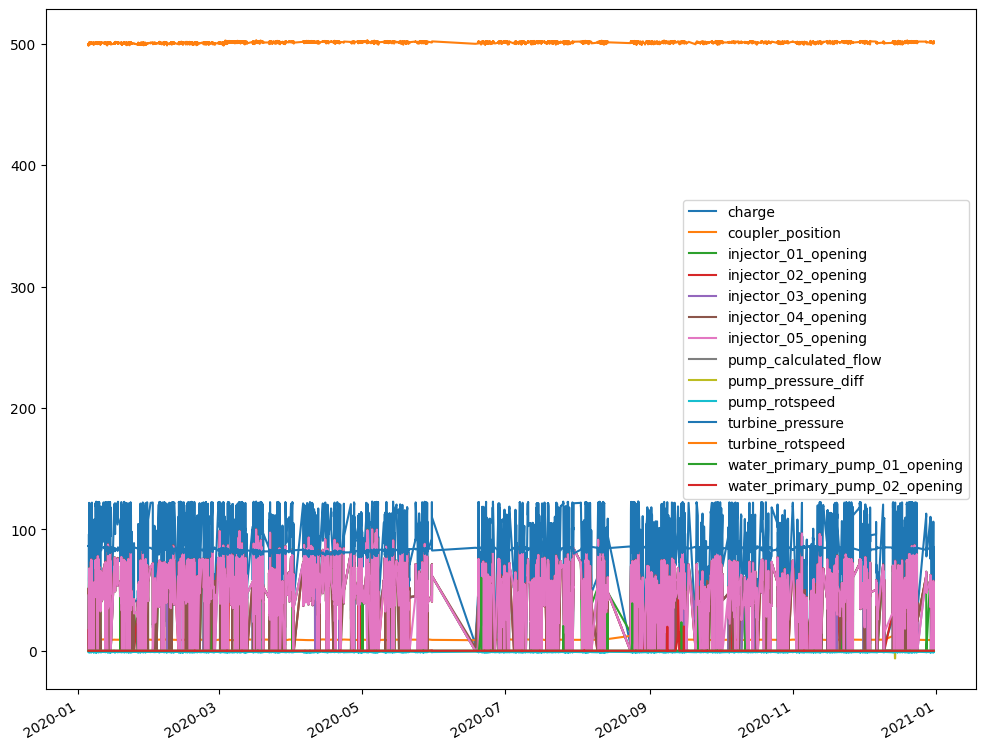

In [8]:
control_df_turbine_steady_state[::50].plot(figsize=(12,10))

<Axes: >

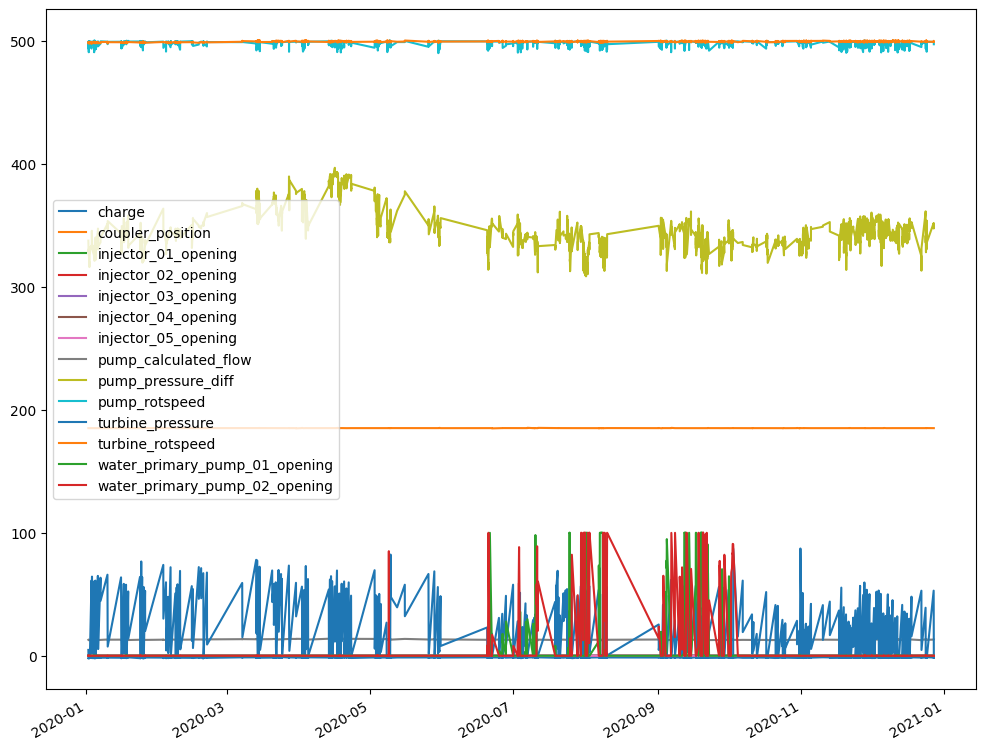

In [9]:
control_df_pump_steady_state[::50].plot(figsize=(12,10))

<Axes: >

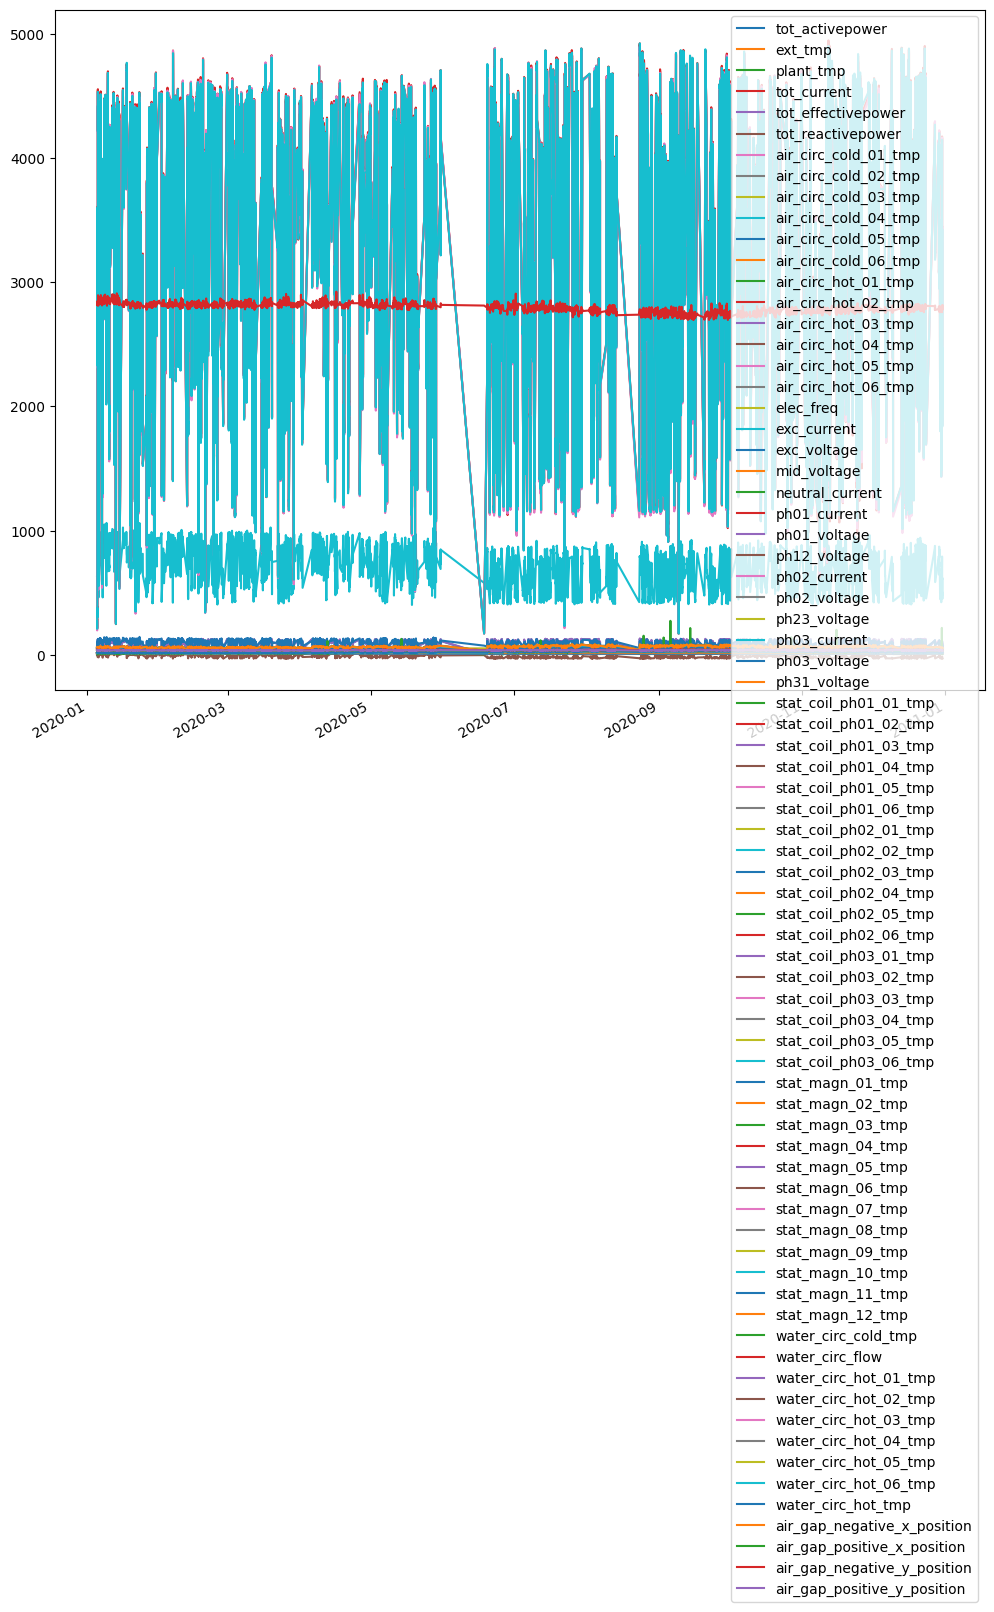

In [10]:
sensors_df_turbine_steady_state[::50].plot(figsize=(12,10))

<Axes: >

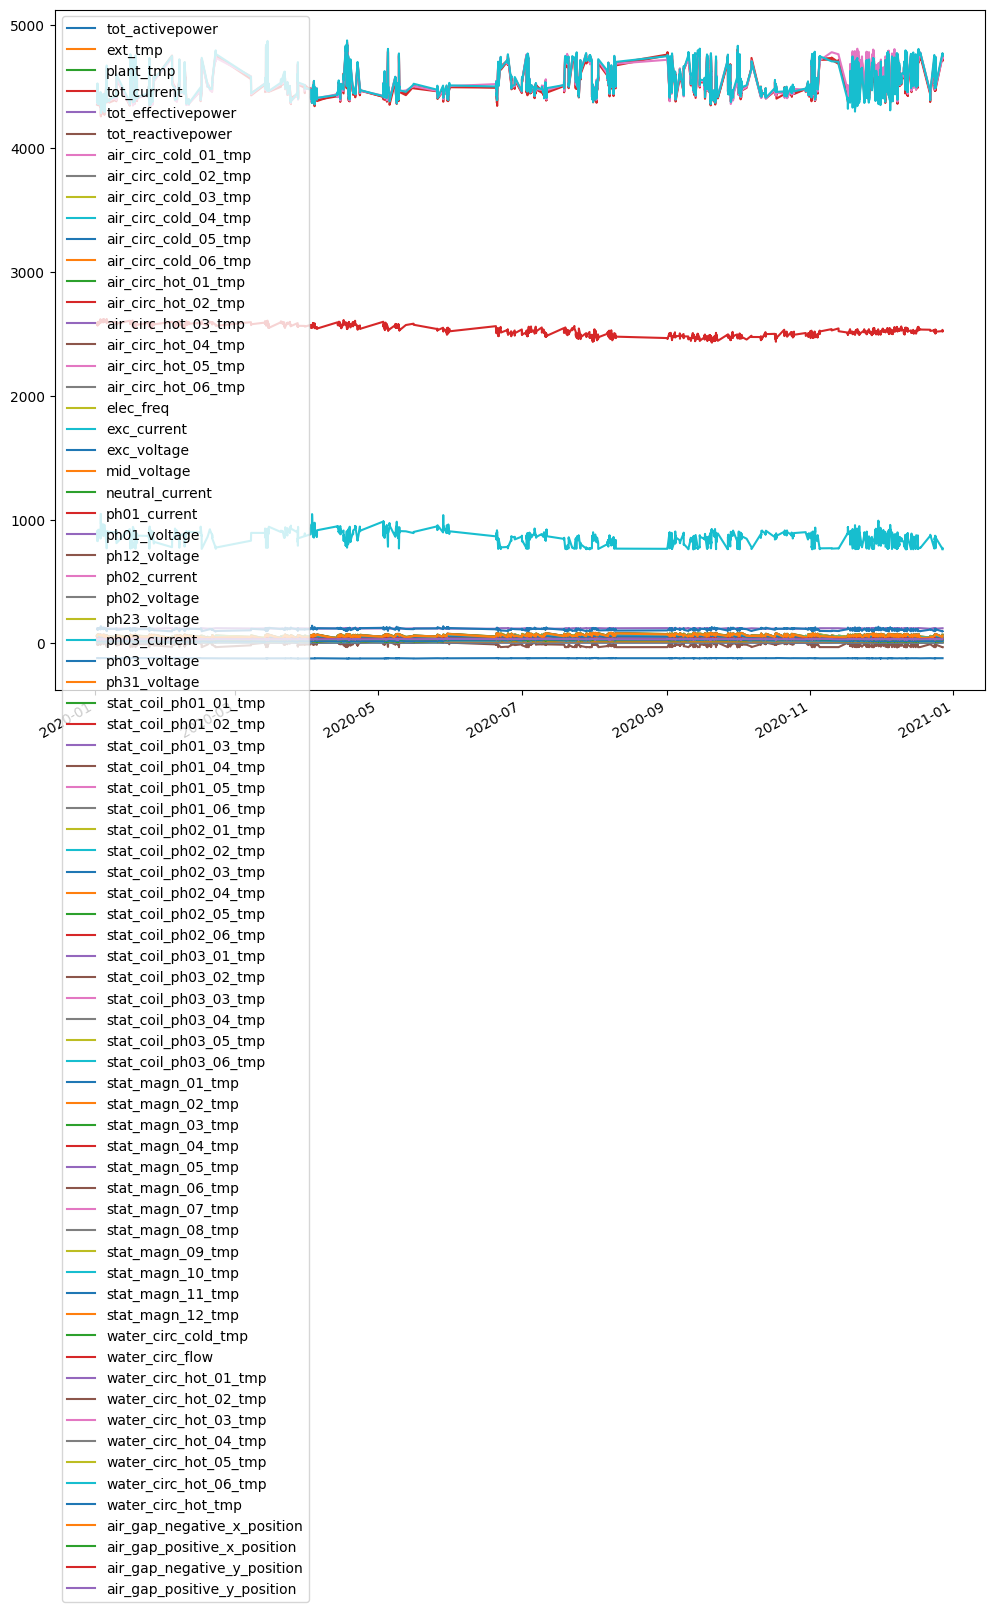

In [11]:
sensors_df_pump_steady_state[::50].plot(figsize=(12,10))

Text(0.5, 1.0, 'Heatmap of the correlation pump steady-state')

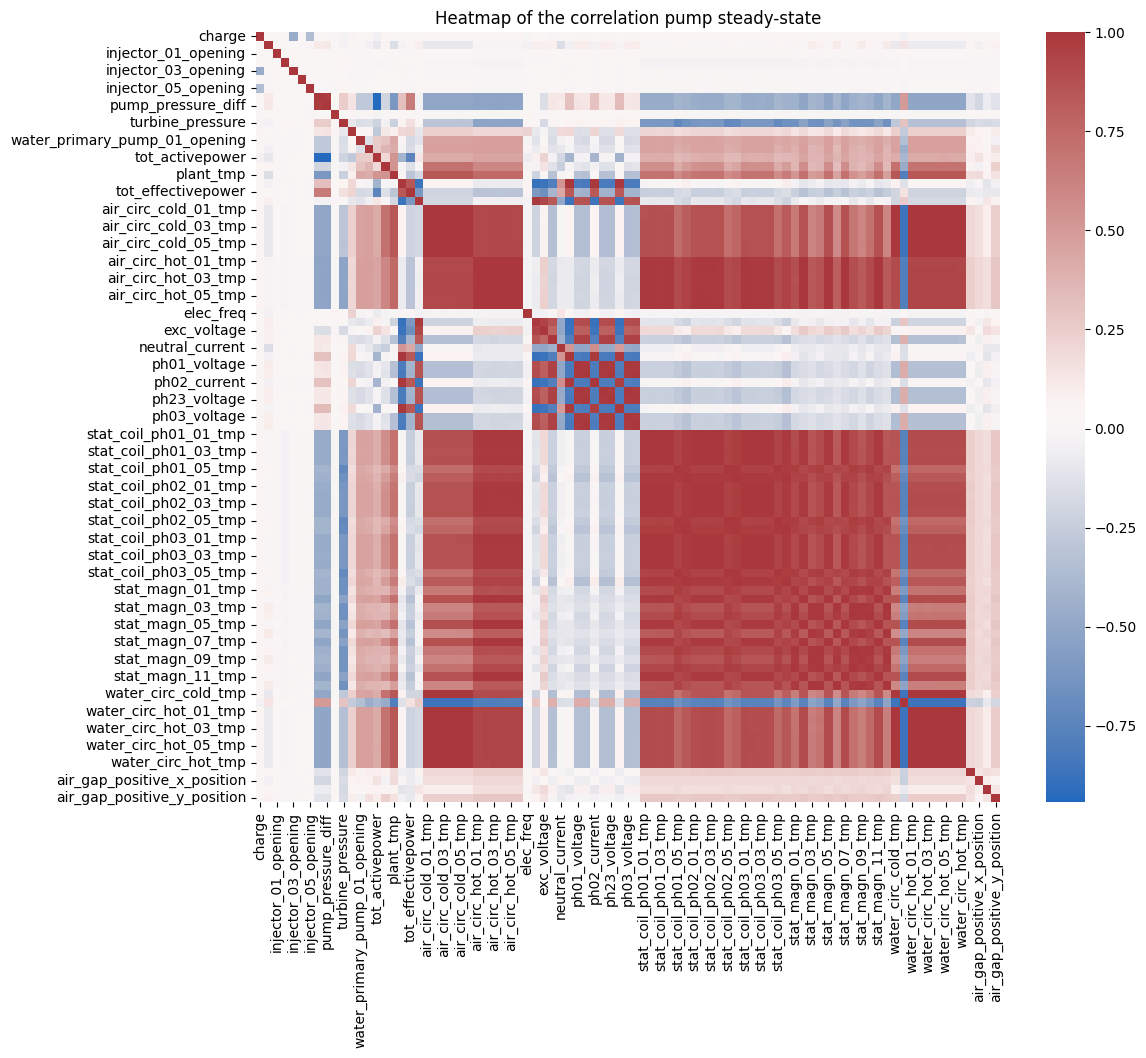

In [12]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
pump_steady_state_concat = pd.concat([control_df_pump_steady_state,sensors_df_pump_steady_state],axis=1)
pump_steady_state_corr = pump_steady_state_concat.corr()
sns.heatmap(pump_steady_state_corr, 
            cmap="vlag")
plt.title("Heatmap of the correlation pump steady-state")

In [13]:
# Extract strongly correlated pairs
strong_corr_pairs = pump_steady_state_corr[(pump_steady_state_corr.abs() >= 0.6) 
                                           & (pump_steady_state_corr != 1.0)]

# Drop NaN values and unstack to get pairs
strong_corr_pairs = strong_corr_pairs.unstack().dropna()

# Select unique pairs
strong_corr_pairs = strong_corr_pairs[strong_corr_pairs.index.get_level_values(0) < strong_corr_pairs.index.get_level_values(1)]

strong_corr_pairs

pump_calculated_flow   pump_pressure_diff       0.976951
                       tot_activepower         -0.932948
                       tot_effectivepower       0.656589
pump_pressure_diff     tot_activepower         -0.942682
                       tot_effectivepower       0.663323
                                                  ...   
water_circ_hot_04_tmp  water_circ_hot_06_tmp    0.998530
                       water_circ_hot_tmp       0.997357
water_circ_hot_05_tmp  water_circ_hot_06_tmp    0.998165
                       water_circ_hot_tmp       0.996990
water_circ_hot_06_tmp  water_circ_hot_tmp       0.996266
Length: 1449, dtype: float64

In [14]:
strong_corr_pairs.index

MultiIndex([( 'pump_calculated_flow',    'pump_pressure_diff'),
            ( 'pump_calculated_flow',       'tot_activepower'),
            ( 'pump_calculated_flow',    'tot_effectivepower'),
            (   'pump_pressure_diff',       'tot_activepower'),
            (   'pump_pressure_diff',    'tot_effectivepower'),
            (      'tot_activepower',    'tot_effectivepower'),
            (              'ext_tmp',   'water_circ_cold_tmp'),
            (              'ext_tmp', 'water_circ_hot_01_tmp'),
            (              'ext_tmp', 'water_circ_hot_02_tmp'),
            (              'ext_tmp', 'water_circ_hot_03_tmp'),
            ...
            ('water_circ_hot_03_tmp', 'water_circ_hot_04_tmp'),
            ('water_circ_hot_03_tmp', 'water_circ_hot_05_tmp'),
            ('water_circ_hot_03_tmp', 'water_circ_hot_06_tmp'),
            ('water_circ_hot_03_tmp',    'water_circ_hot_tmp'),
            ('water_circ_hot_04_tmp', 'water_circ_hot_05_tmp'),
            ('water_circ

Text(0.5, 1.0, 'Heatmap of the correlation turbine steady-state')

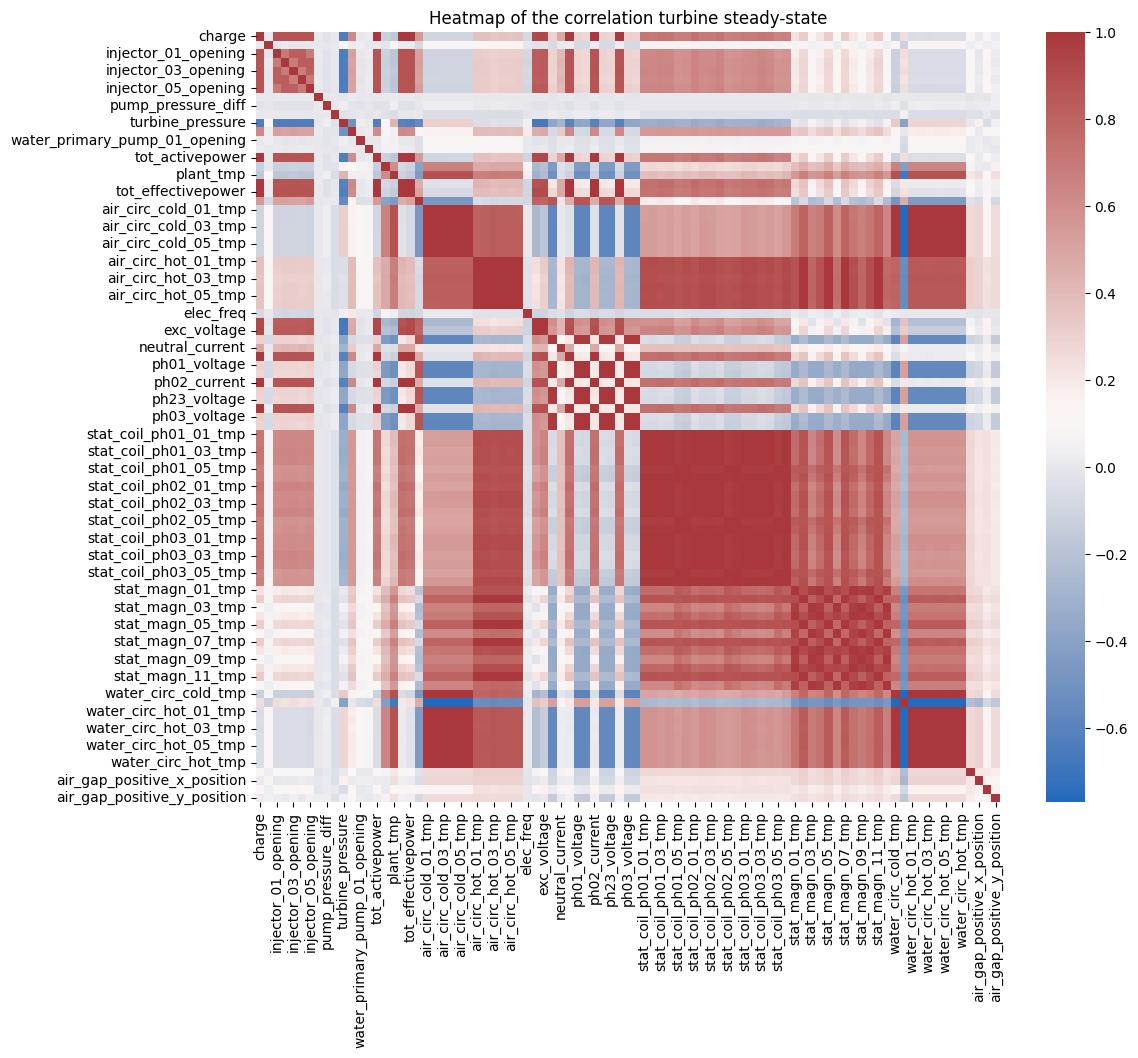

In [15]:
f, ax = plt.subplots(1, 1, figsize=(12, 10))
turbine_steady_state_concat = pd.concat([control_df_turbine_steady_state,sensors_df_turbine_steady_state],
                                        axis=1)
sns.heatmap(turbine_steady_state_concat[::50].corr()
            , cmap="vlag")
plt.title("Heatmap of the correlation turbine steady-state")

# Implementing Principal Component Analysis (PCA)

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the training data
scaler = StandardScaler()
pump_steady_state_scaled = scaler.fit_transform(pump_steady_state_concat[::50])
print(f'The shape of the dataframe is : {pump_steady_state_scaled.shape}')

# Apply PCA on the training data
pca = PCA(n_components=60)
pump_steady_state_pca = pca.fit_transform(pump_steady_state_scaled)
print(f'The shape of dataframe after PCA is : {pump_steady_state_pca.shape}')

The shape of the dataframe is : (2628, 89)
The shape of dataframe after PCA is : (2628, 60)


In [17]:
import numpy as np
# Calculate the reconstruction error for the training data
pump_steady_state_scaled_reconstructed = pca.inverse_transform(pump_steady_state_pca)
reconstruction_error = np.mean((pump_steady_state_scaled - pump_steady_state_scaled_reconstructed)**2, 
                               axis=1)

print(f'The reconstruction error from the _turbinePCA is : {np.linalg.norm(reconstruction_error)}')

The reconstruction error from the _turbinePCA is : 0.0005333328047758004


In [18]:
# Set the threshold for anomalies (e.g., mean + 3*std of reconstruction error)
threshold = np.mean(reconstruction_error) +  0.25*np.std(reconstruction_error)

## Test on the synthetic dataset

Now we are trying the PCA on the synthetic dataset.

In [19]:
control_df_s01, sensors_df_s01, operating_modes_df_s01 = extracting_groups_time_series(rds_u5,'test_s01')

index_pump_steady_state_s01 = get_indexes_operating_mode(operating_modes_df_s01,
                                                        operating_conditions_pump_steady_state)

control_df_pump_steady_state_s01 = control_df_s01.loc[index_pump_steady_state_s01]
sensors_df_pump_steady_state_s01 = sensors_df_s01.loc[index_pump_steady_state_s01]

pump_steady_state_s01_concat = pd.concat([control_df_pump_steady_state_s01,
                                          sensors_df_pump_steady_state_s01],
                                          axis=1)

pump_steady_state_s01_scaled = scaler.transform(pump_steady_state_s01_concat)

pump_steady_state_s01_pca = pca.transform(pump_steady_state_s01_scaled)

# Calculate the reconstruction error for the test data
pump_steady_state_s01_reconstructed = pca.inverse_transform(pump_steady_state_s01_pca)
test_reconstruction_error = np.mean((pump_steady_state_s01_scaled - pump_steady_state_s01_reconstructed)**2,
                                     axis=1)

# Detect anomalies based on the threshold
anomalies = np.abs(test_reconstruction_error) > np.abs(threshold)

print("Test Data Reconstruction Error:")
print(np.linalg.norm(test_reconstruction_error))
print("Anomalies Detected:")
print(all(anomalies))

Test Data Reconstruction Error:
0.603237368579528
Anomalies Detected:
True


It's not working real well. Let's try other classifiers

## One-class SVM

In [20]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import RocCurveDisplay

In [21]:
# Define the OneClassSVM
svm = OneClassSVM(kernel='rbf', nu=0.2)  # You can adjust 'nu' as needed

# Fit OneClassSVM using PCA-transformed training features
svm.fit(pump_steady_state_pca)

OneClassSVM(nu=0.2)

In [22]:
predicted_scores = svm.score_samples(pump_steady_state_s01_pca)
print(predicted_scores.shape)

(21164,)


Threshold for anomalies: 106.1252721414865


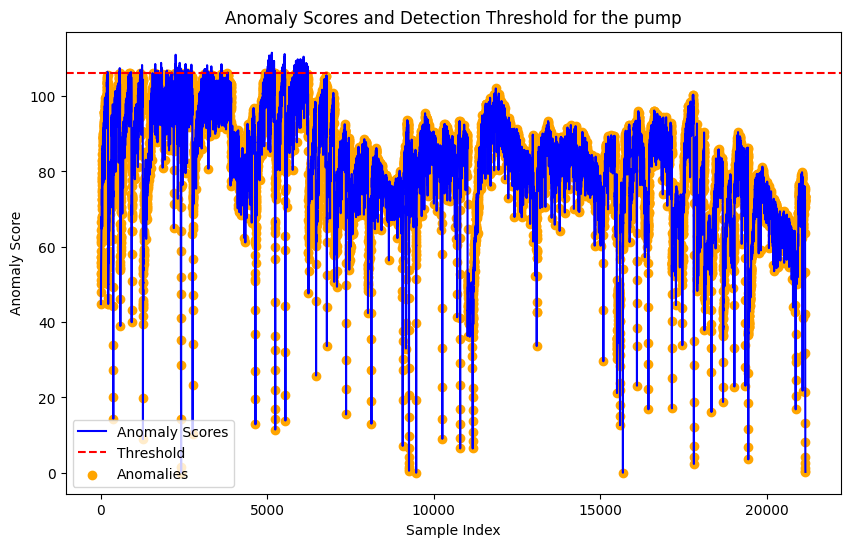

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define a threshold for anomaly detection
# You can use the 95th percentile of the training scores as a threshold
threshold = np.percentile(svm.score_samples(pump_steady_state_pca), 95)
print(f'Threshold for anomalies: {threshold}')

# Classify the test set as normal or anomalous
predictions = predicted_scores < threshold  # True for anomalies, False for normal

# Visualization (optional)
plt.figure(figsize=(10, 6))
plt.plot(predicted_scores, label='Anomaly Scores', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(predictions)[0], predicted_scores[predictions], color='orange', label='Anomalies')
plt.title('Anomaly Scores and Detection Threshold for the pump')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()
#plt.savefig("images/anomaly_scores_detection_turbine.pdf",format='pdf')

### Trying on the turbine now

In [25]:
# Standardize the training data
scaler_turbine = StandardScaler()
turbine_steady_state_scaled = scaler_turbine.fit_transform(turbine_steady_state_concat[::100])
print(f'The shape of the dataframe is : {turbine_steady_state_scaled.shape}')

# Apply PCA on the training data
pca_turbine = PCA(n_components=60)
turbine_steady_state_pca = pca_turbine.fit_transform(turbine_steady_state_scaled)
print(f'The shape of dataframe after PCA is : {turbine_steady_state_pca.shape}')

The shape of the dataframe is : (3323, 89)
The shape of dataframe after PCA is : (3323, 60)


In [26]:
index_turbine_steady_state_s01 = get_indexes_operating_mode(operating_modes_df_s01,
                                                        operating_conditions_turbine_steady_state)

control_df_turbine_steady_state_s01 = control_df_s01.loc[index_turbine_steady_state_s01]
sensors_df_turbine_steady_state_s01 = sensors_df_s01.loc[index_turbine_steady_state_s01]

turbine_steady_state_s01_concat = pd.concat([control_df_turbine_steady_state_s01,
                                          sensors_df_turbine_steady_state_s01],
                                          axis=1)


turbine_steady_state_s01_scaled = scaler_turbine.transform(turbine_steady_state_s01_concat[::2])

turbine_steady_state_s01_pca = pca_turbine.transform(turbine_steady_state_s01_scaled)

print(turbine_steady_state_s01_pca.shape)

(22615, 60)


In [27]:
# Define the OneClassSVM
svm_turbine = OneClassSVM(kernel='rbf', nu=0.2)  # You can adjust 'nu' as needed

# Fit OneClassSVM using PCA-transformed training features
svm_turbine.fit(turbine_steady_state_pca)

OneClassSVM(nu=0.2)

In [28]:
predicted_scores_turbine = svm.score_samples(turbine_steady_state_s01_pca)
print(predicted_scores_turbine.shape)

(22615,)


Threshold for anomalies: 108.44443468815251


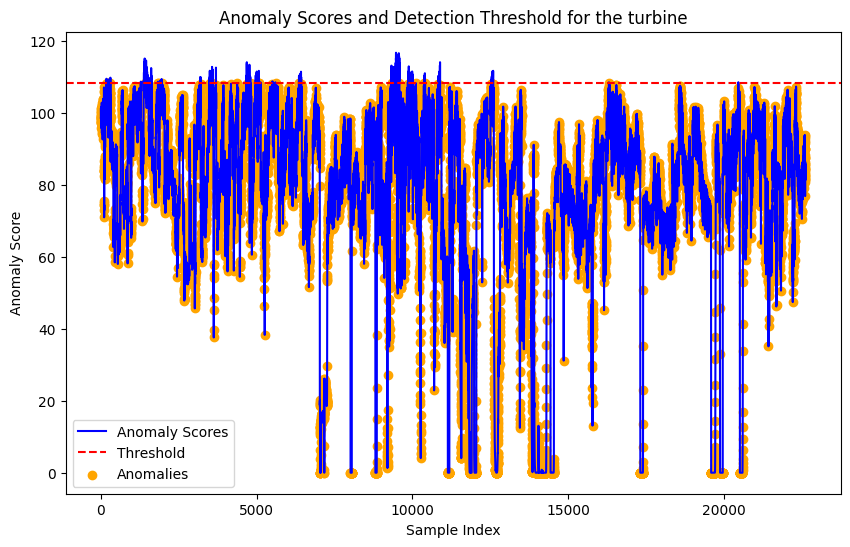

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define a threshold for anomaly detection
# You can use the 95th percentile of the training scores as a threshold
threshold_turbine = np.percentile(svm.score_samples(turbine_steady_state_pca), 95)
print(f'Threshold for anomalies: {threshold_turbine}')

# Classify the test set as normal or anomalous
predictions_turbine = predicted_scores_turbine < threshold_turbine  # True for anomalies, False for normal

# Visualization (optional)
plt.figure(figsize=(10, 6))
plt.plot(predicted_scores_turbine, label='Anomaly Scores', color='blue')
plt.axhline(y=threshold_turbine, color='red', linestyle='--', label='Threshold')
plt.scatter(np.where(predictions_turbine)[0], predicted_scores_turbine[predictions_turbine], 
            color='orange', label='Anomalies')
plt.title('Anomaly Scores and Detection Threshold for the turbine')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()
#plt.savefig("images/anomaly_scores_detection_turbine.pdf",format='pdf')

# Implementing the Vector Autoregressive eXogeneous variable (VARX)

Since the dataset is too large, it is going to be subsample to 1/50 or to 1/100 of its values. The VARX looks like the following 🤓 :

$$
    Y_t = c + \sum_{i=1}^p A_i Y_{t-i} + \sum_{i=1}^p B_i X_{t-i} + \mu_t
$$

With $c$ a constance vector and $\mu_t$ a random vector that simulates the noise.

## Trying on all the data 

In [ ]:
control_df_pump_steady_state[::100].shape

(1314, 14)

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

# Create and fit the VARX model
model = VARMAX(endog=sensors_df_pump_steady_state, 
               exog=control_df_pump_steady_state, 
               order=(1, 0))  # p is the lag order for Y
model_fitted = model.fit(disp=False)

print(model_fitted.summary())

/home/matthieu/Documents/ML predictive maintenance/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Didn't converge after 1H50 of training.

## Focusing on strongly correlated variables

Since the training is way too long, we'll focus on creating an autoregressive model for the injectors.

In [ ]:
injector_df = control_df_turbine_steady_state[['injector_01_opening',"injector_02_opening"]]

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(injector_df)

model.select_order(15)

results = model.fit(maxlags=15, ic='aic')

results.summary()

/home/matthieu/Documents/ML predictive maintenance/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 04, Nov, 2024
Time:                     15:21:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.82789
Nobs:                     332220.    HQIC:                   3.82647
Log likelihood:      -1.57826e+06    FPE:                    45.8736
AIC:                      3.82589    Det(Omega_mle):         45.8650
--------------------------------------------------------------------
Results for equation injector_01_opening
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.271996         0.011341           23.984           0.000
L1.injector_01_opening          0.963187         0.001904          505.915           0.000
L1.inj

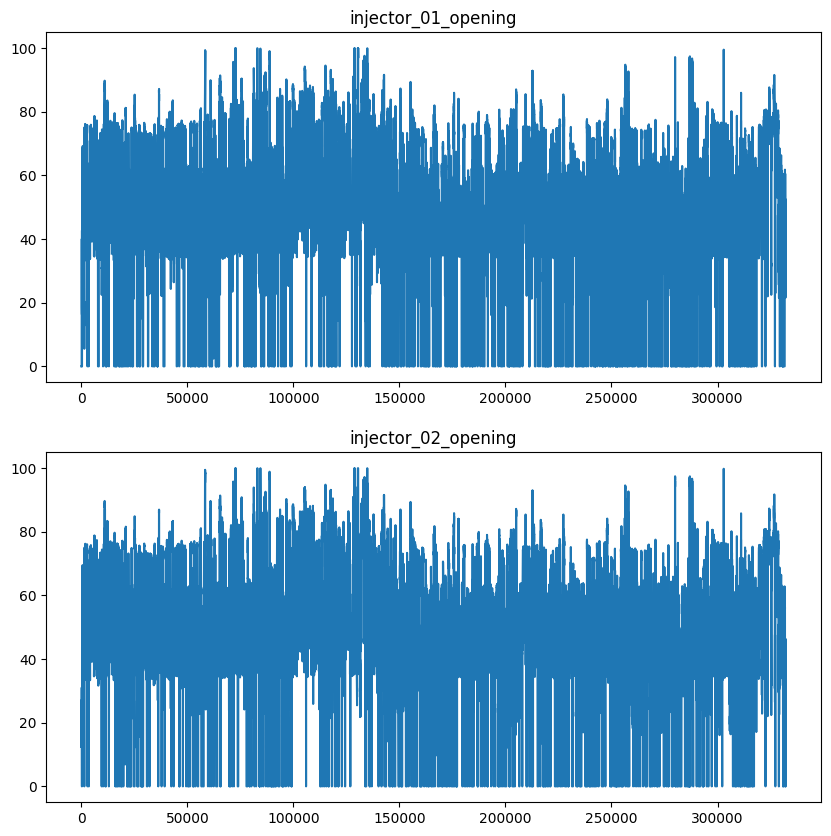

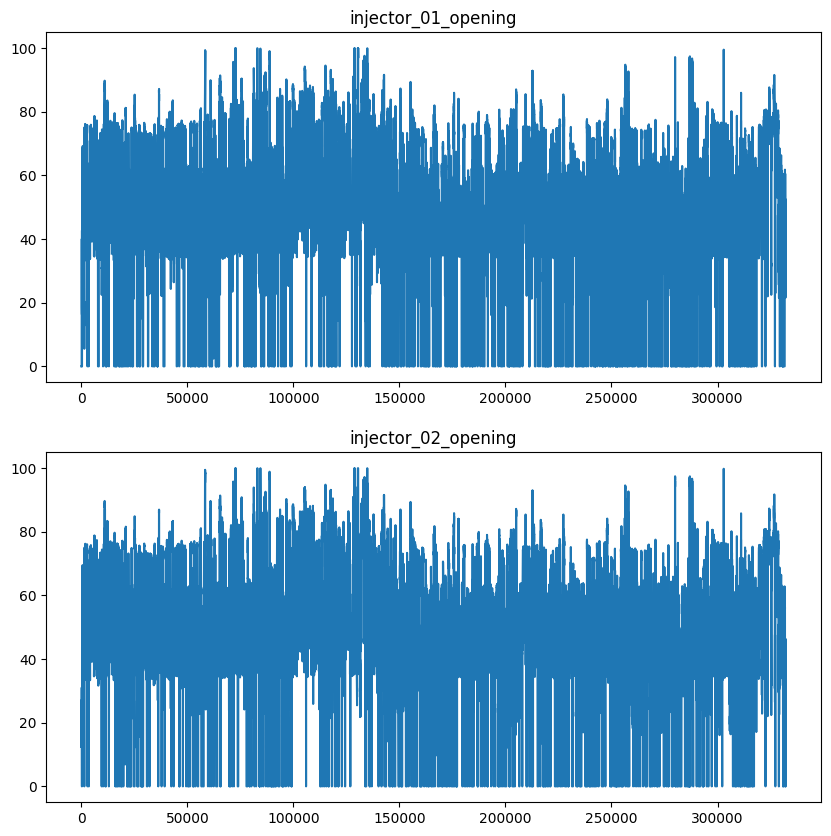

In [ ]:
results.plot()

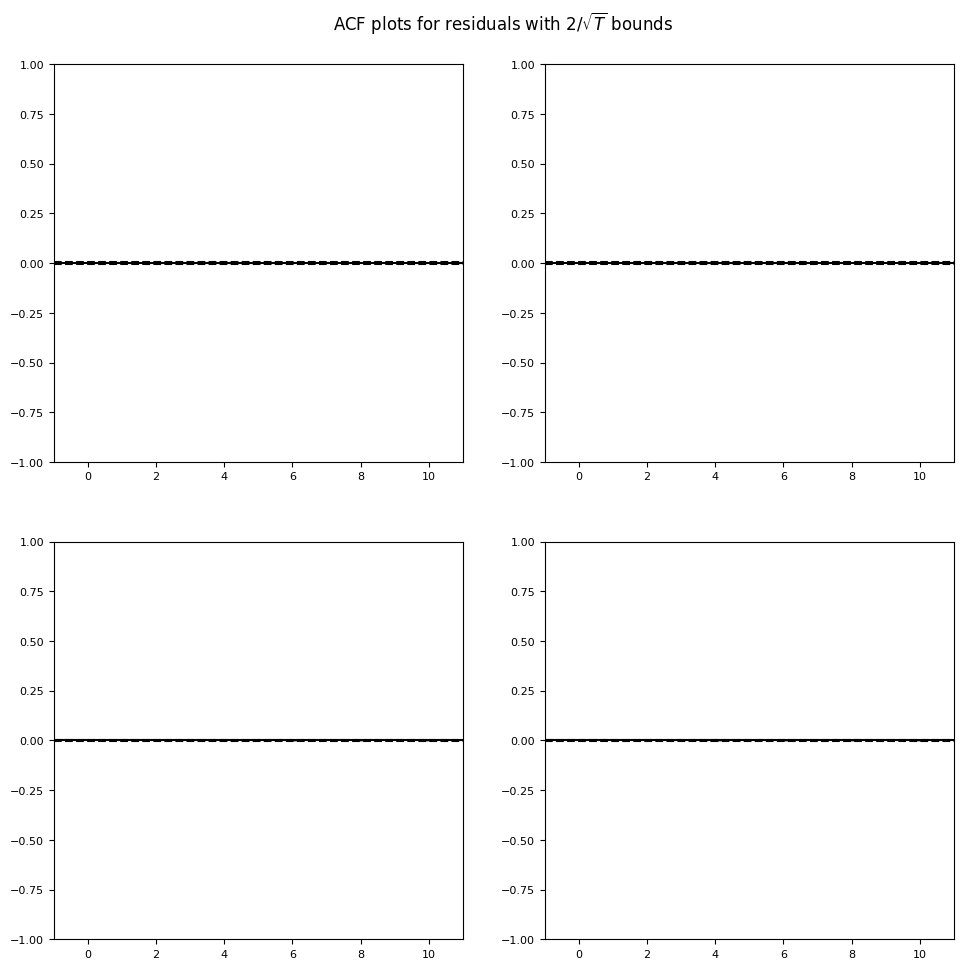

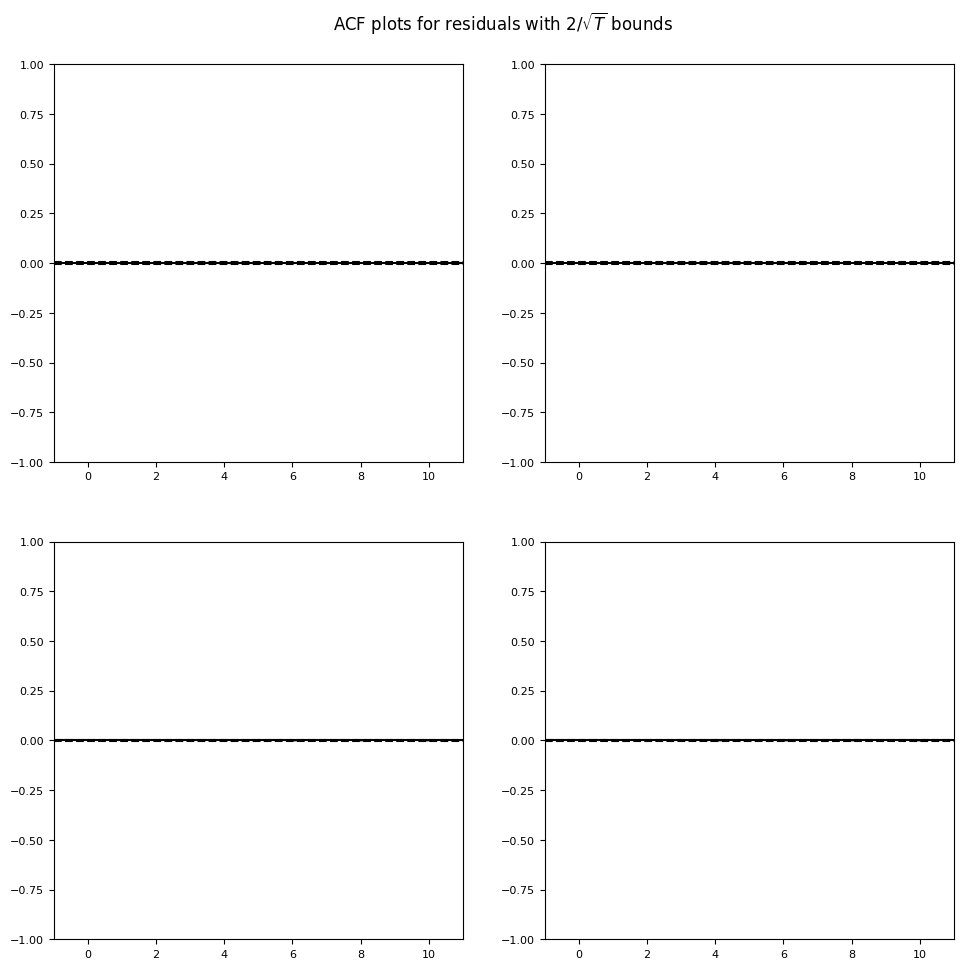

In [ ]:
results.plot_acorr()

In [55]:
results.forecast(injector_df.values[-15:], 5)

array([[34.87715961, 34.5591233 ],
       [34.74755387, 34.43747678],
       [34.7195584 , 34.42378774],
       [34.64355265, 34.36592175],
       [34.6574504 , 34.4127436 ]])

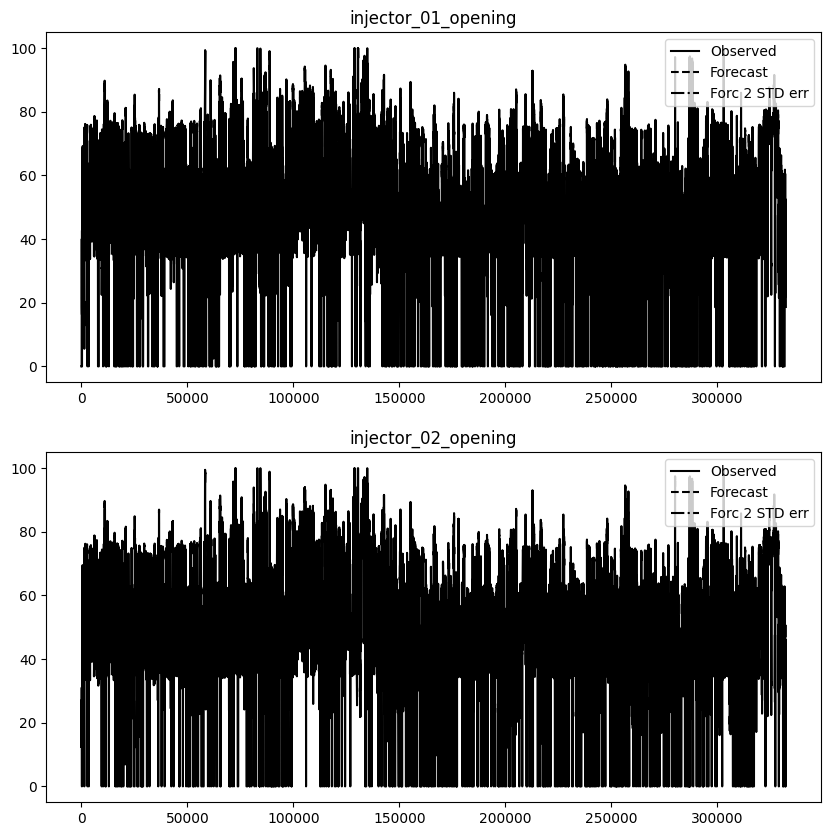

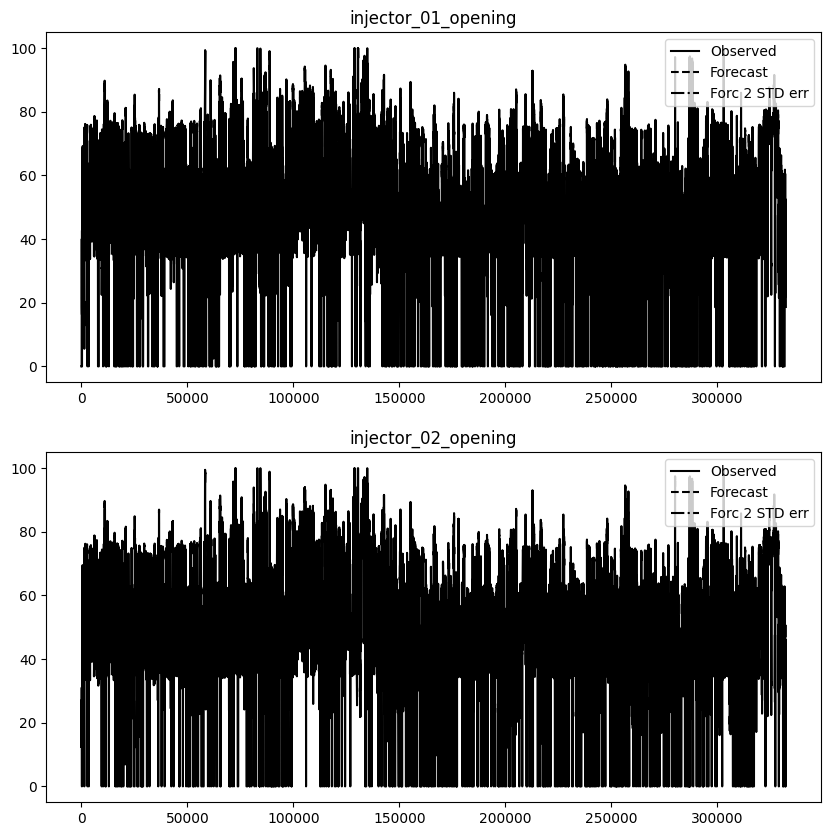

In [56]:
results.plot_forecast(10)

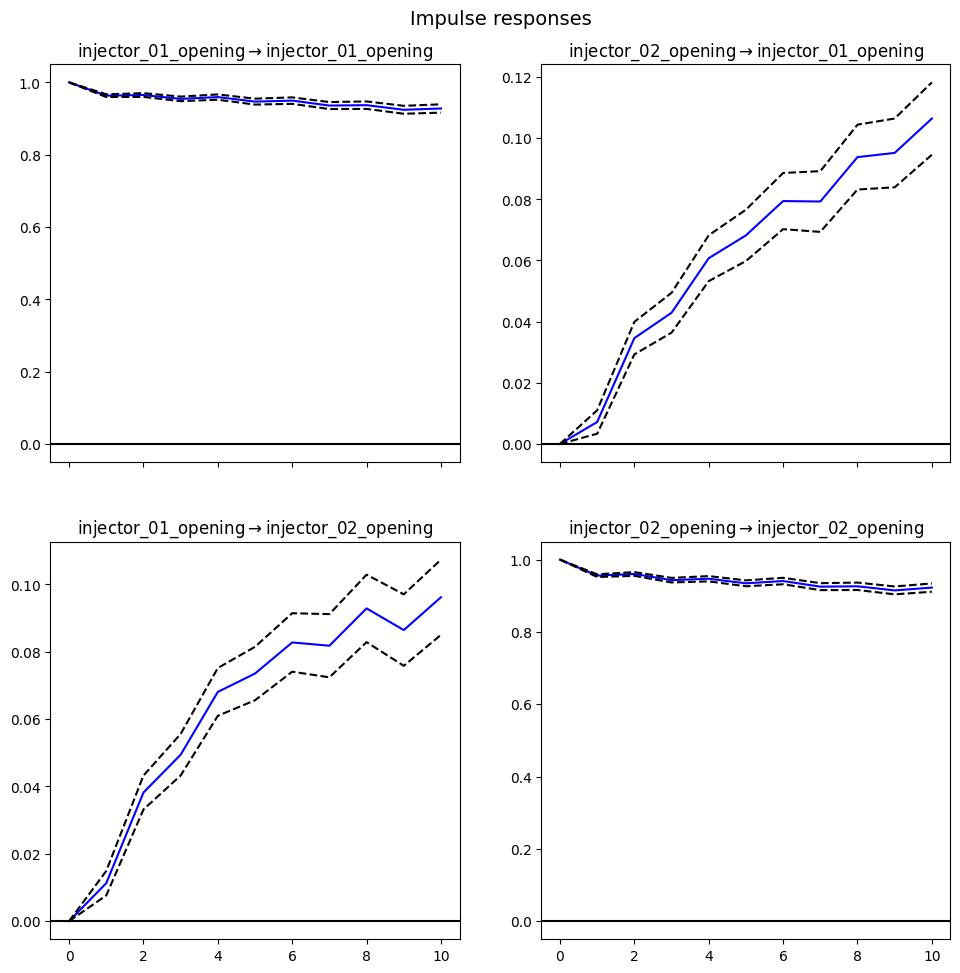

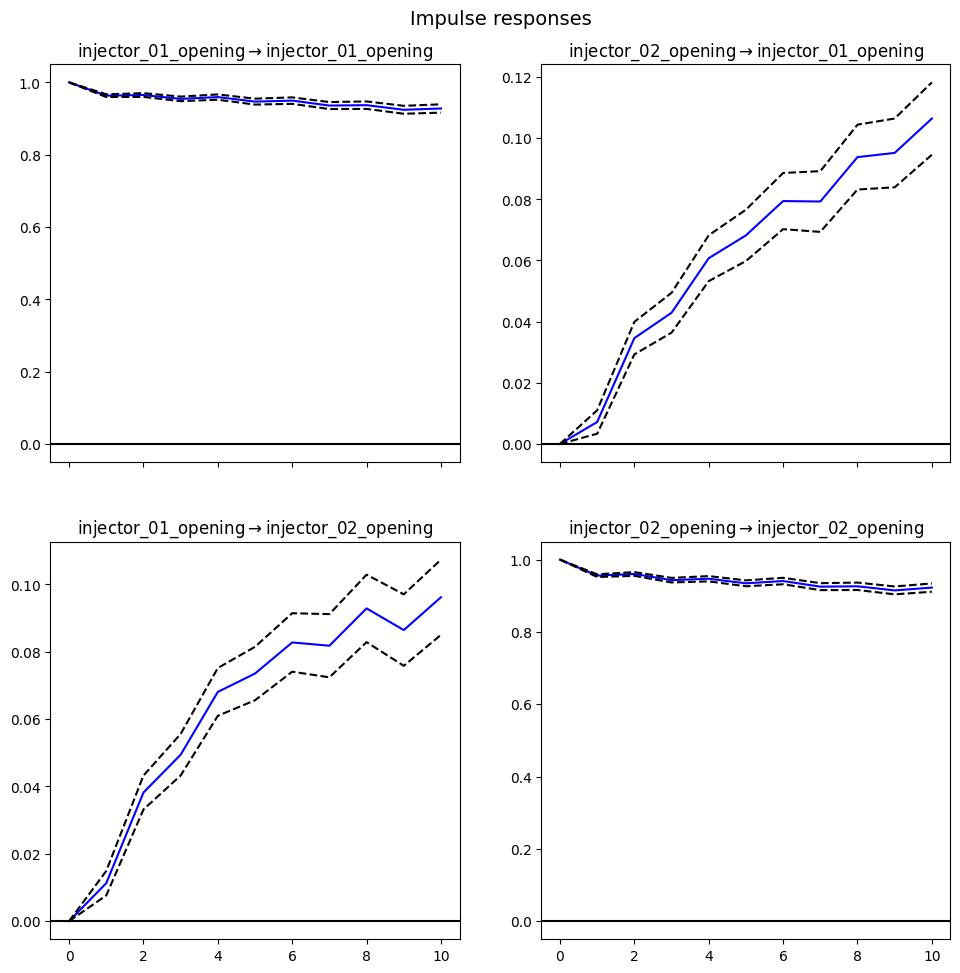

In [57]:
irf = results.irf(10)
irf.plot(orth=False)

In [61]:
injector_estimated = results.forecast(injector_df.values[-15:], 100)

In [65]:
injector_estimated.shape

(100, 2)

In [69]:
import numpy as np
print(np.linalg.norm(injector_df[:100] - injector_estimated)/np.sqrt(100))

43.03271136216541


Try to compare this value to the synthetic dataset

In [ ]:
control_df_s01, sensors_df_s01, operating_modes_df_s01 = extracting_groups_time_series(rds_u5,'test_s01')

operating_conditions_turbine_steady_state = {"dyn_only_on" : False,
                                            "turbine_mode" : True,
                                            "equilibrium_turbine_mode" : True}

index_turbine_steady_state_s01 = get_indexes_operating_mode(operating_modes_df_s01,
                                                        operating_conditions_turbine_steady_state)

control_df_turbine_steady_state_s01 = control_df_s01.loc[index_turbine_steady_state_s01]

In [ ]:
injector_df_s01 = control_df_turbine_steady_state_s01[['injector_01_opening',"injector_02_opening"]]

In [78]:
injector_estimated_s01 = results.forecast(injector_df_s01.values[100:], 100)

print(np.linalg.norm(injector_df_s01[100:200] - injector_estimated_s01)/np.sqrt(100))

18.353024226438425


### Tests for the training

In [ ]:
# Downsampling
control_df_turbine_steady_state = control_df_turbine_steady_state[::1000]
sensors_df_turbine_steady_state = sensors_df_turbine_steady_state[::1000]

print(control_df_turbine_steady_state.shape)
print(sensors_df_turbine_steady_state.shape)

(333, 14)
(333, 75)


In [ ]:
control_df_turbine_steady_state[::5].shape

(67, 14)

Snippet of code to check the stationarity

In [ ]:
#%pip install statsmodels
from statsmodels.tsa.stattools import adfuller

adfuller(control_df_turbine_steady_state["pump_calculated_flow"])

ValueError: Invalid input, x is constant

In [ ]:
from statsmodels.tsa.statespace.varmax import VARMAX

model = VARMAX(endog=sensors_df_turbine_steady_state, 
               exog=control_df_turbine_steady_state, 
               trend="n",
               order=(1, 0))  # p is the lag order for Y
model_fitted = model.fit(disp=False)

print(model_fitted.summary())


/home/matthieu/Documents/ML predictive maintenance/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyboardInterrupt: 

# Tests

In [8]:
control_time_series_name, sensors_time_series_name = extracting_name_groups_time_series(rds_u5)

df = rds_u5.data_dict["train"].measurements

df_steady_state = df[(df["dyn_only_on"] == False) & 
                    (df["pump_mode"] == True) &
                    (df["equilibrium_pump_mode"] == True)]

In [23]:
control_steady_state = df_steady_state[control_time_series_name]

sensors_steady_state = df_steady_state[sensors_time_series_name]

<Axes: >

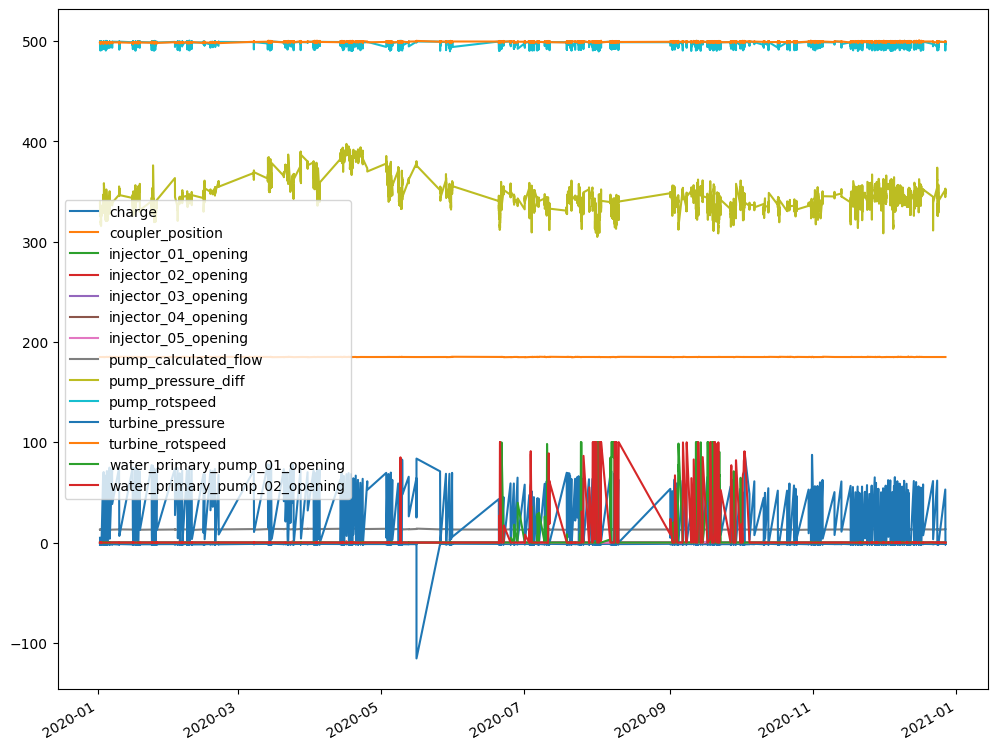

In [21]:
control_steady_state[::10].plot(figsize=(12,10))

<Axes: >

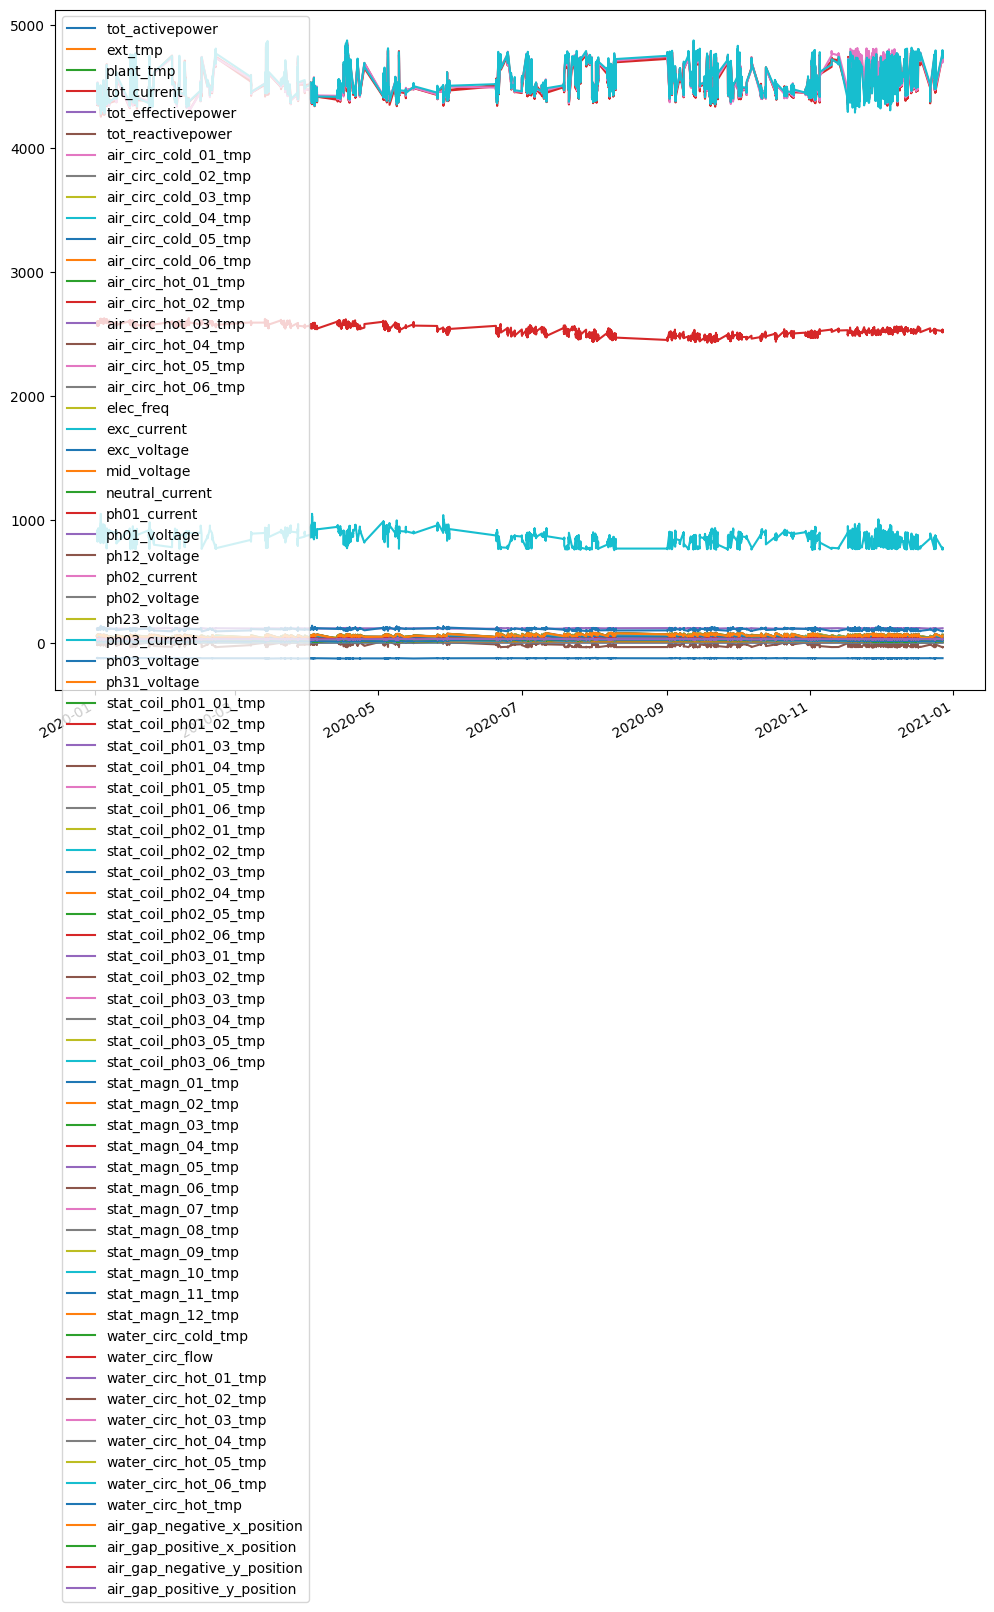

In [24]:
sensors_steady_state[::10].plot(figsize=(12,10))